In [1]:
import numpy as np
import os

# plotting 
import matplotlib.pyplot as plt


# data manager and analysis
import vodex as vx
import numan as nu

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-10e5zszc because the default path (/home/ply/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# DONT TRUST. IT NEEDS TO BE UPDATED. Project structure: 

Provide the project folder with the "processed" folder created in the previous notebook. 

As you keep going with the analysis, the folder will have the following structure: 


```
...........................................................
....................... DONE in 01 ........................
...........................................................
processed                                               ...
│   experiment.json <-----------------------------------... the file that contains everything about the experiment, you are creating it once and will be reusing ever after
│   experiment_dff.json <-------------------------------... everything about the experiment, but loads from the dff movie, not from the raw data                   ...
└───dff_movie  <----------------------------------------...the dff movie :)
│   │   dff_movie_0000.tif                              ...
│   │   dff_movie_0001.tif                              ...
│   │   ...                                             ...
│..........................................................
│...................... DONE in 02 ........................
│..........................................................
│                                                       ...
└───tscore_volumes  <-----------------------------------... t-score tif files
│   │   tscore_SvB.tif <--------------------------------... t-score Stimuli vs Blank
│   │                                                   ...
│..........................................................
│...................... DONE : MANUAL .....................
│..........................................................
└───spots                                               ...
│   └───imaris  <---------------------------- ATTENTION ... You need to put stuff generated by imaris into this folder!!!                                         ...
│       │   └───tscore_SvB_Statistics                   ...
│       │       │     tscore_SvB_Position.csv           ...
│       │       │     tscore_SvB_Diameter.csv           ...
│       │       │     ...                               ...
│..........................................................
│...................... DONE in 03 ........................
│+++++++++++ WILL BE UPDATED in this notebook +++++++++++++
│++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
│   │                                                   +++
│   └───signals  <--------------------------------------+++ json files with the extracted signals, also will have the group info after you added it                 +++
│       │   spots_SvB_max.json                          +++
│       │                                               +++
│++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
│++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
│++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
│   │
│   └───reports  <---------------------------------- tiffs and pdf with the cells significant in any pairwise comparison
│       └───all_significant  <---------------------- tiffs and pdf with all significant in any way cells
│           │   └───signals  <---------------------- pdfs with signals
│           │       │     ...
│           │   └───images <------------------------ tif masks
│           │       │     ...
│       └───groupped  <----------------------------- tiffs and pdf where the cells are groupped based on signal shape .. or anything else you want
│           │   readme.txt  <----------------------- ATTENTION : you need to describe the groups
│           │   └───signals  <---------------------- pdfs with signals
│           │       │     ...
│           │   └───images  <----------------------- tif masks
│           │       │     ...
```

# Set project folder

The processed/spots/signals should already exist and have the extracted signals saved in there. 

In [2]:
project_folder = "/home/ply/repos/numan/notebooks/vodex_si/data/"
project = nu.Project(project_folder)

project.check_exists("processed/spots/signals")

project.activate("processed")

# Load experiment with the raw data:

In [3]:
experiment = vx.Experiment.load('experiment_truncated_drift_corrected.db')

## get the volume ids for the conditions that you will be comparing : 
This is the same as the ones we got in the notebook 02, under " get the volumes corresponding to different conditions "

In [5]:
# indices of the signal timepoints to load ( same as volumes... since one timepoint is 1 volume)
d1_idx = experiment.choose_volumes(("number","d1"))
d2_idx = experiment.choose_volumes(("number","d2"))
d3_idx = experiment.choose_volumes(("number","d3"))
d4_idx = experiment.choose_volumes(("number","d4"))
d5_idx = experiment.choose_volumes(("number","d5"))

# as blank, we will take the timepoints right before the signals
b1_idx = [idx -1 for idx in d1_idx]
b2_idx = [idx -1 for idx in d2_idx]
b3_idx = [idx -1 for idx in d3_idx]
b4_idx = [idx -1 for idx in d4_idx]
b5_idx = [idx -1 for idx in d5_idx]

print(f"We found:\n",
      f"{len(d1_idx)} volumes with 1dot")
print(f" {len(d2_idx)} volumes with 2dot")
print(f" {len(d3_idx)} volumes with 3dot")
print(f" {len(d4_idx)} volumes with 4dot")
print(f" {len(d5_idx)} volumes with 5dot")

We found:
 48 volumes with 1dot
 48 volumes with 2dot
 48 volumes with 3dot
 48 volumes with 4dot
 48 volumes with 5dot


Get wrapper functions ( just run it )

In [7]:
def get_p_values(sa, group1_idx, group2_idx, name_p, vs_blank = False):
    """
    Given SignalAnalyzer and two groups of volume idx, 
    Calculates the p-values for the difference of means for the two groups  (p) 
    and for one volume right before them (p_control). 
    """
    print( f"Getting p-values for {name_p}")
    p = sa.get_p_list_of_difference_of_means(group1_idx, group2_idx)

    return p

def get_significant(p, control = None):
    """
    Figures out what spots have significant p values for the difference of the mean. 
    If control is given, a cell needs to be significant with p and not significant with control.
    """
    sig_p = 0.05
    
    sig = np.array(p)<sig_p
    n_stim = np.sum(sig)
    
    if control is not None:
        sig_control = np.array(control)<sig_p
        n_control = np.sum(sig_control)

        sig = np.logical_and(sig,~sig_control)
        n_sig = np.sum(sig)

        print(f'Significant: {n_sig} | stim only : {n_stim} | control only : {n_control} ')
    else:
        n_sig = n_stim
        print(f'Significant: {n_sig} | stim only : {n_stim}| control not applied')

    return sig

def p_value_histogram(p, ax, title, control = None):
    
    bins = np.arange(0,1.2,0.05)
    ax.hist(p, bins, alpha=0.5, label='stimulus')
    if control is not None:
        ax.hist(control, bins, alpha=0.5, label='control')
    ax.legend(loc='upper right')
    ax.set_title(title)
    
    
def find_significant_spots(spot_tag):
    
    spots = nu.Spots.from_json(f"spots/signals/spots_{spot_tag}.json")
    
    # get dff for each cell
    sliding_window = 15 # in volumes
    # initialise signal analyser with DFF spot signals
    sa = nu.SignalAnalyzer(spots.signals.as_dff(sliding_window))

    # calculate p-values using bootstrap:
    # stimuli vs stimuli; and controls
    # 1v2
    p1v2 = sa.get_p_list_of_difference_of_means(d1_idx, d2_idx)
    p1v2_c = sa.get_p_list_of_difference_of_means(b1_idx, b2_idx)
    sig1v2 = get_significant(p1v2, control = p1v2_c)
    # 1v3
    p1v3 = sa.get_p_list_of_difference_of_means(d1_idx, d3_idx)
    p1v3_c = sa.get_p_list_of_difference_of_means(b1_idx, b3_idx)
    sig1v3 = get_significant(p1v3, control = p1v3_c)
    # 1v4
    p1v4 = sa.get_p_list_of_difference_of_means(d1_idx, d4_idx)
    p1v4_c = sa.get_p_list_of_difference_of_means(b1_idx, b4_idx)
    sig1v4 = get_significant(p1v4, control = p1v4_c)
    # 1v5
    p1v5 = sa.get_p_list_of_difference_of_means(d1_idx, d5_idx)
    p1v5_c = sa.get_p_list_of_difference_of_means(b1_idx, b5_idx)
    sig1v5 = get_significant(p1v5, control = p1v5_c)
    # 2v3
    p2v3 = sa.get_p_list_of_difference_of_means(d2_idx, d3_idx)
    p2v3_c = sa.get_p_list_of_difference_of_means(b2_idx, b3_idx)
    sig2v3 = get_significant(p2v3, control = p2v3_c)
    # 2v4
    p2v4 = sa.get_p_list_of_difference_of_means(d2_idx, d4_idx)
    p2v4_c = sa.get_p_list_of_difference_of_means(b2_idx, b4_idx)
    sig2v4 = get_significant(p2v4, control = p2v4_c)
    # 2v5
    p2v5 = sa.get_p_list_of_difference_of_means(d2_idx, d5_idx)
    p2v5_c = sa.get_p_list_of_difference_of_means(b2_idx, b5_idx)
    sig2v5 = get_significant(p2v5, control = p2v5_c)
    # 3v4
    p3v4 = sa.get_p_list_of_difference_of_means(d3_idx, d4_idx)
    p3v4_c = sa.get_p_list_of_difference_of_means(b3_idx, b4_idx)
    sig3v4 = get_significant(p3v4, control = p3v4_c)
    # 3v5
    p3v5 = sa.get_p_list_of_difference_of_means(d3_idx, d5_idx)
    p3v5_c = sa.get_p_list_of_difference_of_means(b3_idx, b5_idx)
    sig3v5 = get_significant(p3v5, control = p3v5_c)
    # 4v5
    p4v5 = sa.get_p_list_of_difference_of_means(d4_idx, d5_idx)
    p4v5_c = sa.get_p_list_of_difference_of_means(b4_idx, b5_idx)
    sig4v5 = get_significant(p4v5, control = p4v5_c)

    # stimuli vs blank
    p1vB = sa.get_p_list_of_difference_of_means(d1_idx, b1_idx)
    sig1vB = get_significant(p1vB)
    p2vB = sa.get_p_list_of_difference_of_means(d2_idx, b2_idx)
    sig2vB = get_significant(p2vB)
    p3vB = sa.get_p_list_of_difference_of_means(d3_idx, b3_idx)
    sig3vB = get_significant(p3vB)
    p4vB = sa.get_p_list_of_difference_of_means(d4_idx, b4_idx)
    sig4vB = get_significant(p4vB)
    p5vB = sa.get_p_list_of_difference_of_means(d5_idx, b5_idx)
    sig5vB = get_significant(p5vB)

    # ever significant in any way
    sigAny1v2v3v4v5vB = np.logical_or.reduce([sig1v2,sig1v3,sig1v4,sig1v5,
                                              sig2v3,sig2v4,sig2v5,
                                              sig3v4,sig3v5,
                                              sig4v5,
                                              sig1vB,sig2vB,sig3vB,sig4vB,sig5vB])

    # show histograms
    fig, ax = plt.subplots(3, 5, figsize=(15,9), dpi=160)
    ax = ax.flatten()
    fig.suptitle(f"P-values of spots from the T-score image for {spot_tag}")

    p_value_histogram(p1v2, ax[0], '1v2',control = p1v2_c)
    p_value_histogram(p1v3, ax[1], '1v3',control = p1v3_c)
    p_value_histogram(p1v4, ax[2], '1v4',control = p1v4_c)
    p_value_histogram(p1v5, ax[3], '1v5',control = p1v5_c)
    p_value_histogram(p2v3, ax[4], '2v3',control = p2v3_c)
    p_value_histogram(p2v4, ax[5], '2v4',control = p2v4_c)
    p_value_histogram(p2v5, ax[6], '2v5',control = p2v5_c)
    p_value_histogram(p3v4, ax[7], '3v4',control = p3v4_c)
    p_value_histogram(p3v5, ax[8], '3v5',control = p3v5_c)
    p_value_histogram(p4v5, ax[9], '4v5',control = p4v5_c)

    
    p_value_histogram(p1vB, ax[10], '1vB')
    p_value_histogram(p2vB, ax[11], '2vB')
    p_value_histogram(p3vB, ax[12], '3vB')
    p_value_histogram(p4vB, ax[13], '4vB')
    p_value_histogram(p5vB, ax[14], '5vB')
    
    # add the p-values and significance info to the spots
    spots.add_groups({"p1v2":p1v2, "p1v2_c":p1v2_c, "sig1v2":sig1v2,
                      "p1v3":p1v3, "p1v3_c":p1v3_c, "sig1v3":sig1v3,
                      "p1v4":p1v4, "p1v4_c":p1v4_c, "sig1v4":sig1v4,
                      "p1v5":p1v5, "p1v5_c":p1v5_c, "sig1v5":sig1v5,
                      "p2v3":p2v3, "p2v3_c":p2v3_c, "sig2v3":sig2v3,
                      "p2v4":p2v4, "p2v4_c":p2v4_c, "sig2v4":sig2v4,
                      "p2v5":p2v5, "p2v5_c":p2v5_c, "sig2v5":sig2v5,
                      "p3v4":p3v4, "p3v4_c":p3v4_c, "sig3v4":sig3v4,
                      "p3v5":p3v5, "p3v5_c":p3v5_c, "sig3v5":sig3v5,
                      "p4v5":p4v5, "p4v5_c":p4v5_c, "sig4v5":sig4v5,

                      "p1vB":p1vB, "sig1vB":sig1vB,
                      "p2vB":p2vB, "sig2vB":sig2vB,
                      "p3vB":p3vB, "sig3vB":sig3vB,
                      "p4vB":p4vB, "sig4vB":sig4vB,
                      "p5vB":p5vB, "sig5vB":sig5vB,

                      "sigAny1v2v3v4v5vB":sigAny1v2v3v4v5vB})

    spots.to_json(f"spots/signals/spots_{spot_tag}.json")


# Find significant cells and save them 
It will find the p-vlaues for different stimuli pairs and will add this information into the existing files with the spot signals in processed/spots/signals. Those files will be updated, no new files will be created. 

```
processed
└───spots
│   └───signals  <-------------------------------------- (DONE in 03) json files with the extracted signals, also will have the group info after you added it
│       │   spots_spots_.json
│       │     ...
```

Analysing cells from T-score image for SvB_max_________________________________________________________


100%|██████████| 105/105 [00:22<00:00,  4.68it/s]


Significant: 31 | stim only : 34 | control only : 18 


100%|██████████| 105/105 [00:22<00:00,  4.74it/s]


Significant: 67 | stim only : 76 | control only : 17 


100%|██████████| 105/105 [00:22<00:00,  4.59it/s]


Significant: 72 | stim only : 79 | control only : 12 


100%|██████████| 105/105 [00:22<00:00,  4.61it/s]


Significant: 61 | stim only : 70 | control only : 18 


100%|██████████| 105/105 [00:23<00:00,  4.56it/s]


Significant: 27 | stim only : 28 | control only : 9 


100%|██████████| 105/105 [00:22<00:00,  4.68it/s]


Significant: 32 | stim only : 33 | control only : 9 


100%|██████████| 105/105 [00:22<00:00,  4.58it/s]


Significant: 21 | stim only : 23 | control only : 7 


100%|██████████| 105/105 [00:22<00:00,  4.71it/s]


Significant: 4 | stim only : 6 | control only : 6 


100%|██████████| 105/105 [00:22<00:00,  4.73it/s]


Significant: 10 | stim only : 10 | control only : 4 


100%|██████████| 105/105 [00:22<00:00,  4.71it/s]


Significant: 5 | stim only : 5 | control only : 2 


100%|██████████| 105/105 [00:22<00:00,  4.68it/s]


Significant: 102 | stim only : 102| control not applied


100%|██████████| 105/105 [00:22<00:00,  4.70it/s]


Significant: 69 | stim only : 69| control not applied


100%|██████████| 105/105 [00:22<00:00,  4.67it/s]


Significant: 23 | stim only : 23| control not applied


100%|██████████| 105/105 [00:22<00:00,  4.64it/s]


Significant: 15 | stim only : 15| control not applied


100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


Significant: 21 | stim only : 21| control not applied


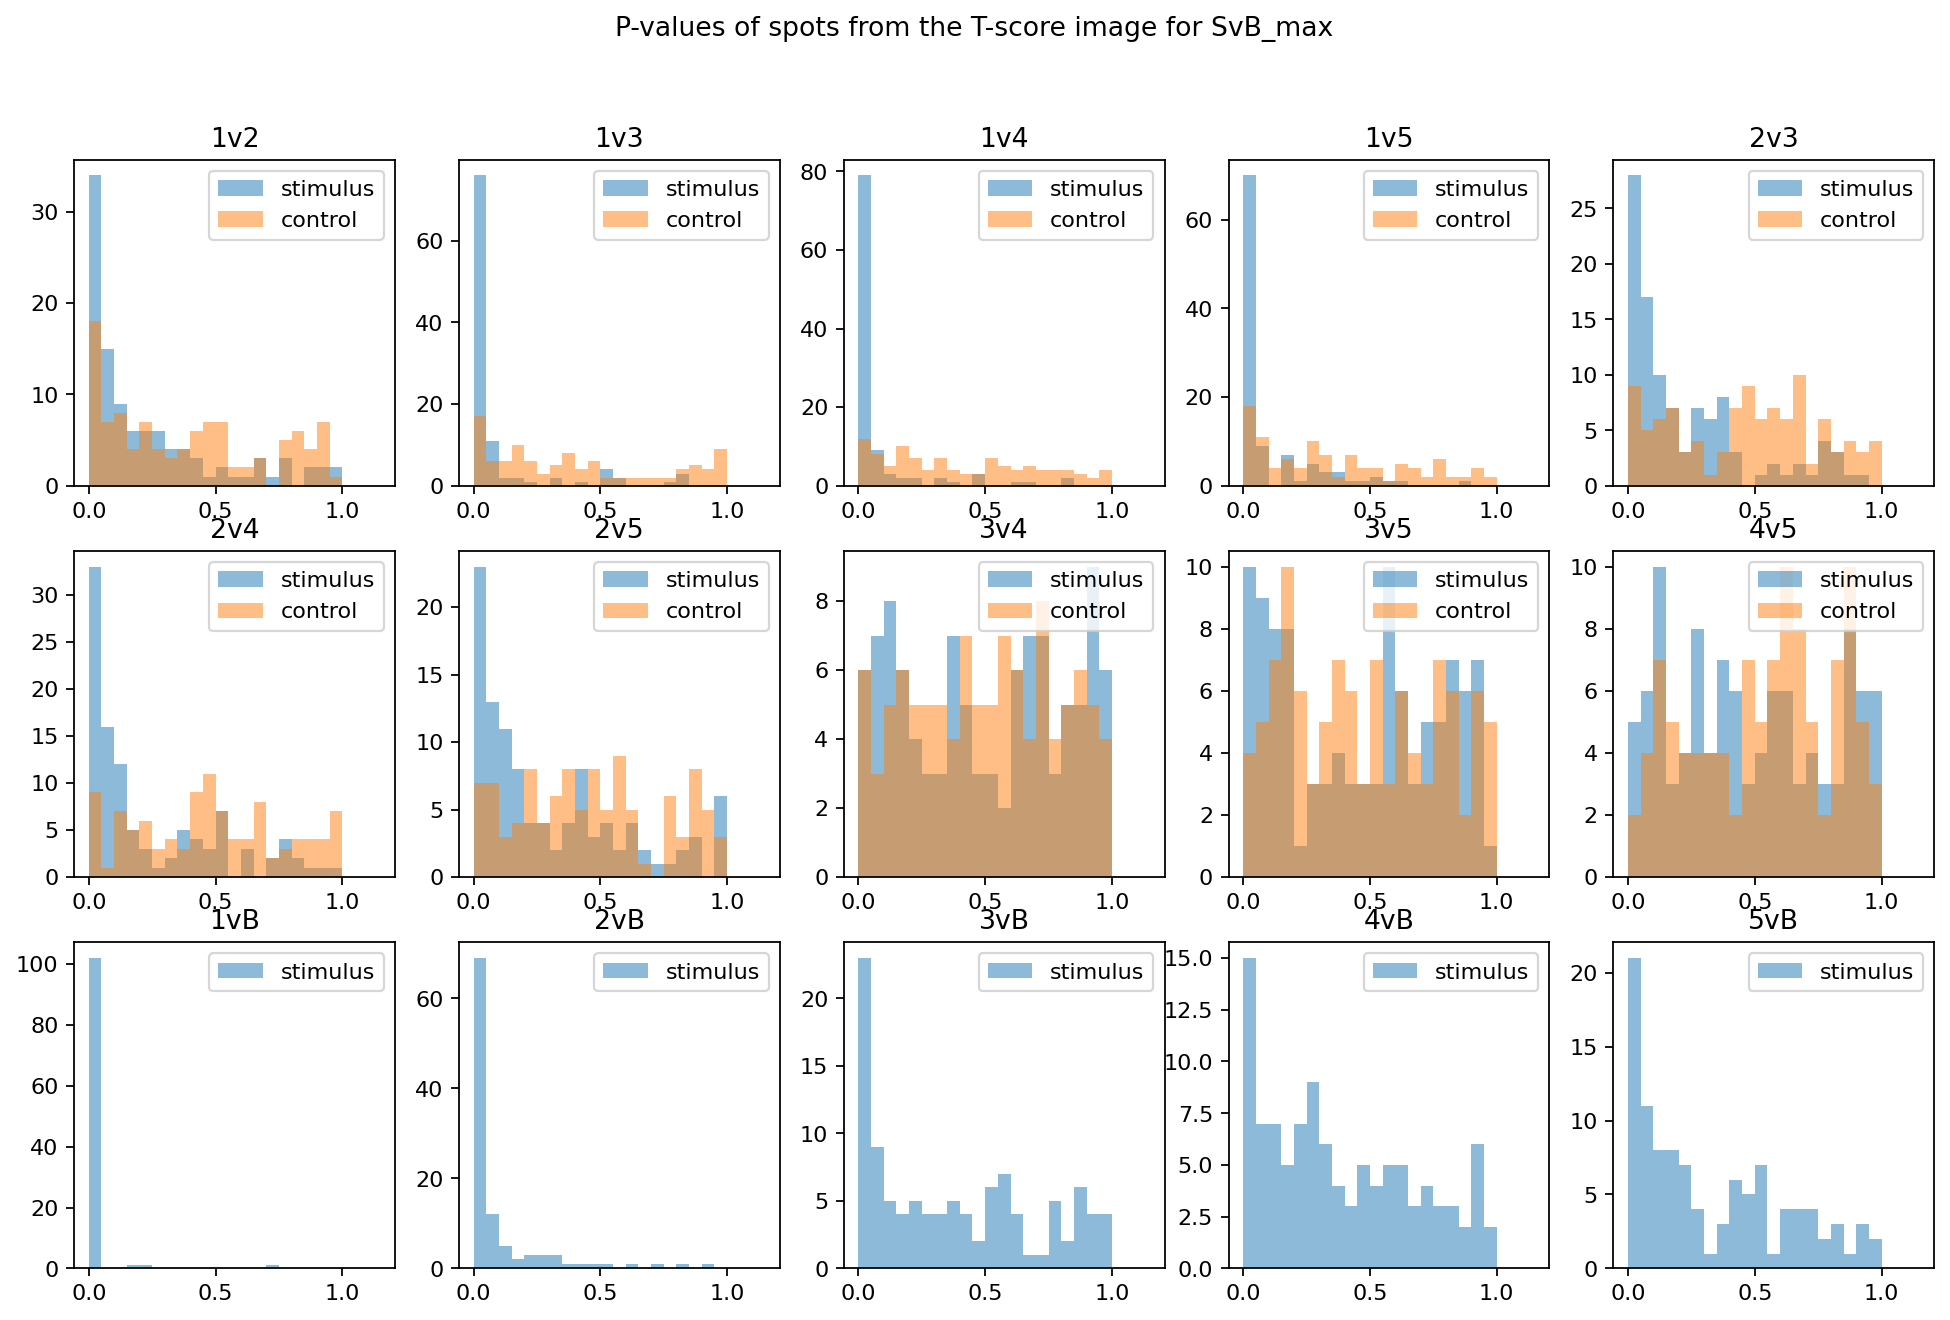

In [8]:
np.random.seed(42)

tag = "SvB_max"
print(f"Analysing cells from T-score image for {tag}_________________________________________________________")
find_significant_spots(tag)